This notebook is the same as `TRIAL_3.ipynb` but instead of `Gender` as the Classifier, I used `Age` as the Classifier. `Gender` is now the considered sensitive attribute.

# Necessities

In [1]:
# ------------------------------------------------------------------
# Imports
# ------------------------------------------------------------------
# Basic data processing libraries
import pandas as pd
import numpy as np
import os
import torch

# Graph data processing libraries
import networkx as nx
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx

# Libraries for (G)NNs
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
import torch.nn as nn

# ------------------------------------------------------------------
# Helper functions
# ------------------------------------------------------------------
def show_df_info(df):
    print(df.info())
    print('####### Repeat ####### \n', df.duplicated().any())
    print('####### Count ####### \n', df.nunique())
    print('####### Example ####### \n',df.head())

def label_statics(label_df, label_list):
    print("####### nCount #######")
    for label in label_list:
        print(label_df[label].value_counts())
    print("####### nPercent #######")
    for label in label_list:
        print(label_df[label].value_counts()/label_df.shape[0])

# ------------------------------------------------------------------
# Data stuff
# ------------------------------------------------------------------
base_path = os.getcwd()
input_ali_data_path = os.path.join(base_path, "input_ali_data")

# Load the data files
user_labels_path = os.path.join(input_ali_data_path, "user_labels.csv")
user_edges_path = os.path.join(input_ali_data_path, "user_edge.csv")

# Create dataframes to store the information from the .csv files
user_labels = pd.read_csv(user_labels_path)
user_edges = pd.read_csv(user_edges_path)

In [2]:
# Prepare the data for GNNs
node_features = torch.tensor(user_labels.iloc[:, 1:].values, dtype=torch.float)
edge_index = torch.tensor(user_edges.values, dtype=torch.long).t().contiguous()

# node_features = torch.tensor(filtered_user_labels.iloc[:, 1:].values, dtype=torch.float)
# edge_index = torch.tensor(filtered_edges.values, dtype=torch.long).t().contiguous()

# Create torch-geometric data
data = Data(x=node_features, edge_index=edge_index)

num_nodes = node_features.size(0)
num_classes = 2 # Binarised gender values from the data
num_node_features = data.num_node_features

# Create masks for training, and testing
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

# 80 - 20 Train and Test data split
num_train = int(num_nodes * 0.8)
train_mask[:num_train] = True
test_mask[num_train:] = True

data.train_mask = train_mask
data.test_mask = test_mask

# Labels from the data (in this case: Gender Classification)
data.y = torch.tensor(user_labels['bin_age'].values, dtype=torch.long)
# data.y = torch.tensor(filtered_user_labels['bin_age'].values, dtype=torch.long)

In [3]:
counts_train = torch.bincount(data.y[data.train_mask])
counts_test = torch.bincount(data.y[data.test_mask])
print(f"Test data: {counts_test} \nTrain data: {counts_train}")

Test data: tensor([19069, 14323]) 
Train data: tensor([76306, 57260])


# Loss Functions

In [4]:
def fairness_aware_loss(output, data, sensitive_attr, alpha=0, beta=0, gamma=0, delta=0):
    target = data.y[data.train_mask]
    # standard_loss = F.cross_entropy(output, target)
    standard_loss = F.nll_loss(output, target)

    labels = data.y[train_mask]
    pos_prob = torch.sigmoid(output[:, 1])
    neg_prob = 1 - pos_prob
    predictions = output.argmax(dim=1)

    # Statistical Parity Regularization
    sp_reg = torch.abs(pos_prob[sensitive_attr == 1].mean() - pos_prob[sensitive_attr == 0].mean())

    # Calculating FPR and TPR for each group
    fpr_group1 = ((predictions == 1) & (labels == 0) & (sensitive_attr == 1)).float().mean()
    fpr_group0 = ((predictions == 1) & (labels == 0) & (sensitive_attr == 0)).float().mean()
    tpr_group1 = ((predictions == 1) & (labels == 1) & (sensitive_attr == 1)).float().mean()
    tpr_group0 = ((predictions == 1) & (labels == 1) & (sensitive_attr == 0)).float().mean()

    # Difference in FPR and TPR between the two groups for Equalized Odds
    fpr_diff = torch.abs(fpr_group1 - fpr_group0)
    tpr_diff = torch.abs(tpr_group1 - tpr_group0)

    # Combine FPR and TPR differences for Equalized Odds Regularization
    equalized_odds_reg = fpr_diff + tpr_diff

    # Treatment Equality Regularization
    fp_diff = (neg_prob * (labels == 0) * (sensitive_attr == 1)).float().mean() - \
              (neg_prob * (labels == 0) * (sensitive_attr == 0)).float().mean()
    fn_diff = (pos_prob * (labels == 1) * (sensitive_attr == 1)).float().mean() - \
              (pos_prob * (labels == 1) * (sensitive_attr == 0)).float().mean()
    treatment_reg = torch.abs(fp_diff) + torch.abs(fn_diff)
    # treatment_reg = torch.abs(fn_diff)

    # fn_group_1 = ((predictions == 0) & (labels == 1) & (sensitive_attr == 1)).sum()
    # fp_group_1 = ((predictions == 1) & (labels == 0) & (sensitive_attr == 1)).sum()

    # fn_group_0 = ((predictions == 0) & (labels == 1) & (sensitive_attr == 0)).sum()
    # fp_group_0 = ((predictions == 1) & (labels == 0) & (sensitive_attr == 0)).sum()
    
    # ratio_group_1 = fn_group_1 / fp_group_1 if fp_group_1 != 0 else torch.tensor(float('inf'))
    # ratio_group_0 = fn_group_0 / fp_group_0 if fp_group_0 != 0 else torch.tensor(float('inf'))
    # treatment_reg = torch.abs(ratio_group_1 - ratio_group_0)

    # Equal Opportunity Difference Regularization
    eod_reg = torch.abs((pos_prob * (labels == 1) * (sensitive_attr == 1)).float().mean() - \
                        (pos_prob * (labels == 1) * (sensitive_attr == 0)).float().mean())

    # Overall Accuracy Equality Difference Regularization
    oaed_reg = torch.abs((pos_prob * (sensitive_attr == 1)).float().mean() - \
                         (pos_prob * (sensitive_attr == 0)).float().mean())

    penalty = alpha + beta + gamma + delta
    
    # Combine losses
    combined_loss = (1-penalty)*standard_loss
    + alpha * equalized_odds_reg
    + beta * treatment_reg
    + gamma * eod_reg
    + delta * oaed_reg
    
    return combined_loss

# Calculate Fairness

In [5]:
def calculate_fairness(label, predictions, sens_attr='gender', balanced=False):
    """
    Calculate various fairness metrics.

    Args:
    label: Actual labels (binary).
    predictions: Model predictions (binary).
    sens_attr: Binary sensitive attribute for fairness evaluation.

    Returns:
    A dictionary containing SPD, EOD, OAED, and TED values.
    """
    if balanced is False:
        labels = torch.tensor(user_labels[label].values, dtype=torch.long)
        sensitive_attribute = torch.tensor(user_labels[sens_attr].values, dtype=torch.long)
    else:
        labels = torch.tensor(filtered_user_labels[label].values, dtype=torch.long)
        sensitive_attribute = torch.tensor(filtered_user_labels[sens_attr].values, dtype=torch.long)

    predictions = predictions.float()
    labels = labels.float()
    sensitive_attribute = sensitive_attribute.float()

    def statistical_parity_difference():
        prob_group_1 = predictions[sensitive_attribute == 1].mean()
        prob_group_0 = predictions[sensitive_attribute == 0].mean()
        return abs(prob_group_1 - prob_group_0), prob_group_0, prob_group_1

    def equal_opportunity_difference():
        tpr_group_1 = predictions[(labels == 1) & (sensitive_attribute == 1)].mean()
        tpr_group_0 = predictions[(labels == 1) & (sensitive_attribute == 0)].mean()
        return abs(tpr_group_1 - tpr_group_0), tpr_group_0, tpr_group_1

    def overall_accuracy_equality_difference():
        acc_group_1 = (predictions[sensitive_attribute == 1] == labels[sensitive_attribute == 1]).float().mean()
        acc_group_0 = (predictions[sensitive_attribute == 0] == labels[sensitive_attribute == 0]).float().mean()
        return abs(acc_group_1 - acc_group_0), acc_group_0, acc_group_1

    def treatment_equality_difference():
        fn_group_1 = ((predictions == 0) & (labels == 1) & (sensitive_attribute == 1)).sum()
        fp_group_1 = ((predictions == 1) & (labels == 0) & (sensitive_attribute == 1)).sum()

        fn_group_0 = ((predictions == 0) & (labels == 1) & (sensitive_attribute == 0)).sum()
        fp_group_0 = ((predictions == 1) & (labels == 0) & (sensitive_attribute == 0)).sum()

        ratio_group_1 = fn_group_1 / fp_group_1 if fp_group_1 != 0 else float('inf')
        ratio_group_0 = fn_group_0 / fp_group_0 if fp_group_0 != 0 else float('inf')

        return abs(ratio_group_1 - ratio_group_0), ratio_group_0, ratio_group_1

    # Calculating each fairness metric
    spd, sp_g0, sp_g1 = statistical_parity_difference()
    eod, eod_g0, eod_g1 = equal_opportunity_difference()
    oaed, oaed_g0, oaed_g1 = overall_accuracy_equality_difference()
    ted, ted_g0, ted_g1 = treatment_equality_difference()

    return {
        'Statistical Parity Difference': spd,
        'Statistical Parity Group with S=0': sp_g0,
        'Statistical Parity Group S=1': sp_g1,
        'Equal Opportunity Difference': eod,
        'Equal Opportunity Group with S=0': eod_g0,
        'Equal Opportunity Group S=1': eod_g1,
        'Overall Accuracy Equality Difference': oaed,
        'Overall Accuracy Group with S=0': oaed_g0,
        'Overall Accuracy Group S=1': oaed_g1,
        'Treatment Equality Difference': ted,
        'Treatment Equality Group with S=0': ted_g0,
        'Treatment Equality Group S=1': ted_g1
    }

# Helper Functions

In [6]:
# Train the model
def training(model, data, optimizer, epochs, fairness=False, alpha=0, beta=0, gamma=0, delta=0):

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        
        if fairness:
            loss = fairness_aware_loss(out[data.train_mask], data, data.x[data.train_mask, -1],
                                       alpha=alpha, beta=beta, gamma=gamma, delta=delta)
            
        else:
            # criterion = torch.nn.CrossEntropyLoss()
            criterion = torch.nn.NLLLoss()
            loss = criterion(out[data.train_mask], data.y[data.train_mask])

        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f'Epoch {epoch} | Loss: {loss.item()}')

In [7]:
# Test the model
def test(model, data, balanced=False):
    model.eval()
    with torch.inference_mode():
      out = model(data.x, data.edge_index)

    _, pred = model(data.x, data.edge_index).max(dim=1)
    correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
    accuracy = correct / int(data.test_mask.sum())
    # print(f'Accuracy: {accuracy}')

    # Convert model outputs to binary predictions
    predictions = out.argmax(dim=1)

    # Fairness calculated for gender-classification task with bin_age as the sensitive attribute
    fairness_metrics = calculate_fairness(label='bin_age', predictions=predictions, sens_attr='gender', balanced=balanced)
    
    fairness_metrics['Accuracy'] = accuracy
    # # Print the fairness metrics
    # for metric, value in fairness_metrics.items():
    #     print(f"{metric}: {value}")

    return fairness_metrics


In [8]:
def print_metrics(metrics):
    count = -1

    for key, value in metrics.items():
        count += 1
        if count == 3:
            print(f"\n\n{key} : {value:.5f}")
            count = 0
        else:
            print(f"{key} : {value:.5f}")

# Test the Models

## Baseline

In [10]:
# GCN class that takes in the data as an input for dimensions of the convolutions
class GCN(torch.nn.Module):
    def __init__(self, x, edge_index):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(data.num_node_features, 16)
        self.conv2 = GCNConv(16, 2) # 2 output classes for gender

    def forward(self, x, edge_index, *args, **kwargs):
        # x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [11]:
# Instantiate the model, define loss function and optimizer
gcn_model = GCN(data.x , data.edge_index)
gcn_optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.01)

In [12]:
# Train the first model: GCN, standard data, NLL loss  (AGE as Classifying Attribute, GENDER as Sensitive Attribute)
training(model=gcn_model, data=data, optimizer=gcn_optimizer, epochs=50)

# Test the first model: GCN, standard data, NLL loss  (AGE as Classifying Attribute, GENDER as Sensitive Attribute)
print("Here are the values for the standard GCN model with the standard NLL loss: ")

metrics_base_gcn_model = test(gcn_model, data)

print_metrics(metrics_base_gcn_model)

Epoch 0 | Loss: 0.7857509255409241
Epoch 10 | Loss: 0.6749848127365112
Epoch 20 | Loss: 0.6221828460693359
Epoch 30 | Loss: 0.5799062252044678
Epoch 40 | Loss: 0.5498019456863403
Here are the values for the standard GCN model with the standard NLL loss: 
Statistical Parity Difference : 0.12883
Statistical Parity Group with S=0 : 0.31751
Statistical Parity Group S=1 : 0.44634


Equal Opportunity Difference : 0.04050
Equal Opportunity Group with S=0 : 0.62193
Equal Opportunity Group S=1 : 0.66243


Overall Accuracy Equality Difference : 0.05534
Overall Accuracy Group with S=0 : 0.77919
Overall Accuracy Group S=1 : 0.72386


Treatment Equality Difference : 0.33401
Treatment Equality Group with S=0 : 2.11535
Treatment Equality Group S=1 : 1.78133


Accuracy : 0.76458


In [36]:
from torch_geometric.explain import Explainer, GNNExplainer

explainer = Explainer(
    model=gcn_model,
    algorithm=GNNExplainer(epochs=30),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs', 
    ),
)

In [37]:
explanation = explainer(data.x, data.edge_index)
print(explanation.edge_mask)
print(explanation.node_mask)

tensor([0.4309, 0.4325, 0.4303,  ..., 0.4306, 0.4290, 0.4301])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.4170, 0.4147,  ..., 0.0000, 0.5806, 0.4300],
        [0.0000, 0.3963, 0.4778,  ..., 0.0000, 0.5437, 0.4260],
        ...,
        [0.0000, 0.0000, 0.3980,  ..., 0.4531, 0.0000, 0.3708],
        [0.0000, 0.4390, 0.4117,  ..., 0.4055, 0.0000, 0.3932],
        [0.0000, 0.0000, 0.4479,  ..., 0.0000, 0.0000, 0.4490]])


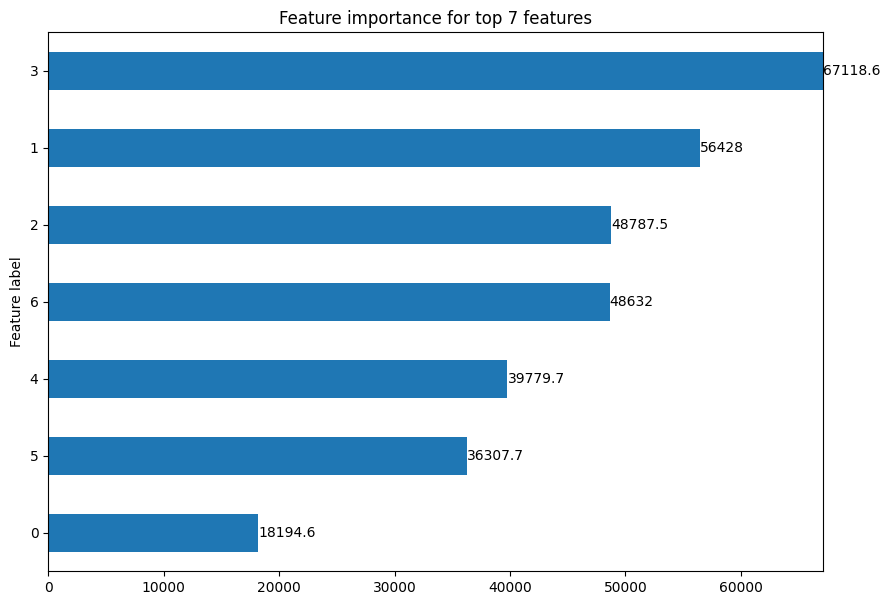

In [38]:
explanation.visualize_feature_importance(top_k=10)

## Fair Models

In [12]:
class FairnessAwareMessagePassingLayer(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(FairnessAwareMessagePassingLayer, self).__init__(aggr='mean')  
        self.lin = nn.Linear(in_channels, out_channels)
        self.a_fair = nn.Parameter(torch.rand(out_channels)) 
        self.sensitive_attr = torch.tensor(user_labels['gender'].values, dtype=torch.float)  
        self.bias_correction = nn.Parameter(torch.rand(1))

    def forward(self, x, edge_index):
        # Add self-loops 
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        x = self.lin(x)

        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x)
    
    def message(self, x_j, edge_index, size):
        row, col = edge_index
        deg = degree(row, size[0], dtype=x_j.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Compute statistical parity difference for each edge
        group_difference = self.sensitive_attr[row] - self.sensitive_attr[col]
        
        # Adjust messages based on statistical parity
        fairness_adjustment = (1 + 1.1*self.bias_correction * group_difference.view(-1, 1))

        return fairness_adjustment * norm.view(-1, 1) * x_j

    def update(self, aggr_out):
        fairness_adjusted_embeddings = aggr_out 
        # * self.a_fair
    
        return fairness_adjusted_embeddings

In [10]:
class custom_GCN(torch.nn.Module):
    def __init__(self, data):
        super(custom_GCN, self).__init__()
        self.conv1 = FairnessAwareMessagePassingLayer(data.num_node_features, 16)
        self.conv2 = FairnessAwareMessagePassingLayer(16, 2) # 2 output classes for gender

    def forward(self, x, edge_index, *args, **kwargs):
        # x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

### First Fair Model

This model is an instantiation of the `custom_GCN` using the standard NLL loss.

In [13]:
model2 = custom_GCN(data)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.01)

# Train the model: Custom MP GNN, NLL loss
training(model=model2, data=data, optimizer=optimizer2, epochs=50)

# Test the first FAIR model: CustomGNN, NLL loss
print("Here are the values for the CustomGNN model with the standard NLL loss: ")

metrics_custom_gnn_model_1 = test(model2, data)

print_metrics(metrics_custom_gnn_model_1)

Epoch 0 | Loss: 0.6936882734298706
Epoch 10 | Loss: 0.6921588778495789
Epoch 20 | Loss: 0.690700113773346
Epoch 30 | Loss: 0.6883592009544373
Epoch 40 | Loss: 0.6850518584251404
Here are the values for the CustomGNN model with the standard NLL loss: 
Statistical Parity Difference : 0.10642
Statistical Parity Group with S=0 : 0.10599
Statistical Parity Group S=1 : 0.21241


Equal Opportunity Difference : 0.09508
Equal Opportunity Group with S=0 : 0.20399
Equal Opportunity Group S=1 : 0.29907


Overall Accuracy Equality Difference : 0.08218
Overall Accuracy Group with S=0 : 0.65923
Overall Accuracy Group S=1 : 0.57705


Treatment Equality Difference : 5.98866
Treatment Equality Group with S=0 : 12.57905
Treatment Equality Group S=1 : 6.59039


Accuracy : 0.63800


In [11]:
model2 = custom_GCN(data)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.01)

# Train the model: Custom MP GNN, NLL loss
training(model=model2, data=data, optimizer=optimizer2, epochs=50)

# Test the first FAIR model: CustomGNN, NLL loss
print("Here are the values for the CustomGNN model with the standard NLL loss: ")

metrics_custom_gnn_model_1 = test(model2, data)

print_metrics(metrics_custom_gnn_model_1)

Epoch 0 | Loss: 0.6936155557632446
Epoch 10 | Loss: 0.6925916075706482
Epoch 20 | Loss: 0.6913859844207764
Epoch 30 | Loss: 0.6893453598022461
Epoch 40 | Loss: 0.6859667897224426
Here are the values for the CustomGNN model with the standard NLL loss: 
Statistical Parity Difference : 0.14529
Statistical Parity Group with S=0 : 0.11573
Statistical Parity Group S=1 : 0.26102


Equal Opportunity Difference : 0.14353
Equal Opportunity Group with S=0 : 0.23164
Equal Opportunity Group S=1 : 0.37516


Overall Accuracy Equality Difference : 0.06325
Overall Accuracy Group with S=0 : 0.67142
Overall Accuracy Group S=1 : 0.60817


Treatment Equality Difference : 7.68801
Treatment Equality Group with S=0 : 12.76595
Treatment Equality Group S=1 : 5.07794


Accuracy : 0.65525


Here are the values for the standard GCN model with the standard NLL loss: 
Statistical Parity Difference : 0.11824
Statistical Parity Group with S=0 : 0.32446
Statistical Parity Group S=1 : 0.44269


Equal Opportunity Difference : 0.02933
Equal Opportunity Group with S=0 : 0.63115
Equal Opportunity Group S=1 : 0.66048


Overall Accuracy Equality Difference : 0.05409
Overall Accuracy Group with S=0 : 0.77956
Overall Accuracy Group S=1 : 0.72547


Treatment Equality Difference : 0.13197
Treatment Equality Group with S=0 : 1.97233
Treatment Equality Group S=1 : 1.84036


Accuracy : 0.76515

### Second Fair Model

This model is an instantiation of the `custom_GCN` using the fair NLL loss.

In [12]:
custom_gnn_model_2 = custom_GCN(data)
optimizer_custom_gnn_model_2 = torch.optim.Adam(custom_gnn_model_2.parameters(), lr=0.01)

fairness=True
alpha, beta, gamma, delta = 0.1, 0.1, 0.1, 0.1

# Train the model: Custom MP GNN, FAIR cross-entropy loss
training(model=custom_gnn_model_2, 
         data=data, 
         optimizer=optimizer_custom_gnn_model_2, 
         fairness=fairness, 
         alpha=alpha, 
         beta=beta, 
         gamma=gamma, 
         delta=delta, 
         epochs=50)

# Test the second FAIR model: CustomGNN, FAIR cross-entropy loss
print("Here are the values for the CustomGNN model with the FAIR standard NLL loss: ")

metrics_custom_gnn_model_2 = test(custom_gnn_model_2, data)

print_metrics(metrics_custom_gnn_model_2)

Epoch 0 | Loss: 0.41584455966949463
Epoch 10 | Loss: 0.41477417945861816
Epoch 20 | Loss: 0.41354653239250183
Epoch 30 | Loss: 0.4114404618740082
Epoch 40 | Loss: 0.40849485993385315
Here are the values for the CustomGNN model with the FAIR standard NLL loss: 
Statistical Parity Difference : 0.11627
Statistical Parity Group with S=0 : 0.10355
Statistical Parity Group S=1 : 0.21983


Equal Opportunity Difference : 0.11377
Equal Opportunity Group with S=0 : 0.21195
Equal Opportunity Group S=1 : 0.32572


Overall Accuracy Equality Difference : 0.07043
Overall Accuracy Group with S=0 : 0.66799
Overall Accuracy Group S=1 : 0.59755


Treatment Equality Difference : 8.84276
Treatment Equality Group with S=0 : 16.02589
Treatment Equality Group S=1 : 7.18313


Accuracy : 0.64914


In [ ]:
custom_gnn_model_2 = custom_GCN(data)
optimizer_custom_gnn_model_2 = torch.optim.Adam(custom_gnn_model_2.parameters(), lr=0.01)

fairness=True
alpha, beta, gamma, delta = 0.01, 0.01, 0.01, 0.01

# Train the model: Custom MP GNN, FAIR cross-entropy loss
training(model=custom_gnn_model_2, 
         data=data, 
         optimizer=optimizer_custom_gnn_model_2, 
         fairness=fairness, 
         alpha=alpha, 
         beta=beta, 
         gamma=gamma, 
         delta=delta, 
         epochs=50)

# Test the second FAIR model: CustomGNN, FAIR cross-entropy loss
print("Here are the values for the CustomGNN model with the FAIR standard NLL loss: ")

metrics_custom_gnn_model_2 = test(custom_gnn_model_2, data)

print_metrics(metrics_custom_gnn_model_2)

Epoch 0 | Loss: 0.66538006067276
Epoch 10 | Loss: 0.6650955677032471
Epoch 20 | Loss: 0.6643511652946472
Epoch 30 | Loss: 0.6624587774276733
Epoch 40 | Loss: 0.657958447933197
Here are the values for the CustomGNN model with the FAIR standard NLL loss: 
Statistical Parity Difference : 0.12334
Statistical Parity Group with S=0 : 0.14453
Statistical Parity Group S=1 : 0.26787


Equal Opportunity Difference : 0.10344
Equal Opportunity Group with S=0 : 0.27734
Equal Opportunity Group S=1 : 0.38077


Overall Accuracy Equality Difference : 0.07166
Overall Accuracy Group with S=0 : 0.67886
Overall Accuracy Group S=1 : 0.60720


Treatment Equality Difference : 3.54959
Treatment Equality Group with S=0 : 8.29413
Treatment Equality Group S=1 : 4.74454


Accuracy : 0.65974


Here are the values for the standard GCN model with the standard NLL loss: 
Statistical Parity Difference : 0.11824
Statistical Parity Group with S=0 : 0.32446
Statistical Parity Group S=1 : 0.44269


Equal Opportunity Difference : 0.02933
Equal Opportunity Group with S=0 : 0.63115
Equal Opportunity Group S=1 : 0.66048


Overall Accuracy Equality Difference : 0.05409
Overall Accuracy Group with S=0 : 0.77956
Overall Accuracy Group S=1 : 0.72547


Treatment Equality Difference : 0.13197
Treatment Equality Group with S=0 : 1.97233
Treatment Equality Group S=1 : 1.84036


Accuracy : 0.76515

### Third FAIR Model

This model is an instantiation of the `custom_GCN` using the fair NLL loss using ONLY large treatment equality penalty.

In [13]:
custom_gnn_model_3 = custom_GCN(data)
optimizer_custom_gnn_model_3 = torch.optim.Adam(custom_gnn_model_3.parameters(), lr=0.01)

fairness=True
alpha, beta, gamma, delta = 0, 0.4, 0, 0

# Train the model: Custom MP GNN, FAIR cross-entropy loss
training(model=custom_gnn_model_3, 
         data=data, 
         optimizer=optimizer_custom_gnn_model_3, 
         fairness=fairness, 
         alpha=alpha, 
         beta=beta, 
         gamma=gamma, 
         delta=delta, 
         epochs=50)

# Test the third FAIR model: CustomGNN, FAIR cross-entropy loss with LARGE TE penalty
print("Here are the values for the CustomGNN model with the FAIR standard NLL loss with LARGE TE penalty: ")

metrics_custom_gnn_model_3 = test(custom_gnn_model_3, data)

print_metrics(metrics_custom_gnn_model_3)

Epoch 0 | Loss: 0.4160410463809967
Epoch 10 | Loss: 0.4151434004306793
Epoch 20 | Loss: 0.4137207865715027
Epoch 30 | Loss: 0.4114552438259125
Epoch 40 | Loss: 0.40851089358329773
Here are the values for the CustomGNN model with the FAIR standard NLL loss with LARGE TE penalty: 
Statistical Parity Difference : 0.10893
Statistical Parity Group with S=0 : 0.11384
Statistical Parity Group S=1 : 0.22277


Equal Opportunity Difference : 0.09951
Equal Opportunity Group with S=0 : 0.22693
Equal Opportunity Group S=1 : 0.32644


Overall Accuracy Equality Difference : 0.07421
Overall Accuracy Group with S=0 : 0.66958
Overall Accuracy Group S=1 : 0.59537


Treatment Equality Difference : 6.03671
Treatment Equality Group with S=0 : 12.85714
Treatment Equality Group S=1 : 6.82043


Accuracy : 0.65013


Here are the values for the standard GCN model with the standard NLL loss: 
Statistical Parity Difference : 0.11824
Statistical Parity Group with S=0 : 0.32446
Statistical Parity Group S=1 : 0.44269


Equal Opportunity Difference : 0.02933
Equal Opportunity Group with S=0 : 0.63115
Equal Opportunity Group S=1 : 0.66048


Overall Accuracy Equality Difference : 0.05409
Overall Accuracy Group with S=0 : 0.77956
Overall Accuracy Group S=1 : 0.72547


Treatment Equality Difference : 0.13197
Treatment Equality Group with S=0 : 1.97233
Treatment Equality Group S=1 : 1.84036


Accuracy : 0.76515

## Attention-based Message Passing

In this section, the models are trained using a custom attention-based message passing model.  
This custom attention should take the sensitive attribute into consideration when calculating the attention weights.

In [14]:
from torch_geometric.nn import GATConv

In [17]:
# GAT class that takes in the data as an input for dimensions of the convolutions
class GAT(torch.nn.Module):
    def __init__(self, data):
        super(GAT, self).__init__()
        self.conv1 = GATConv(data.num_node_features, 16)
        self.conv2 = GATConv(16, 2) # 2 output classes for gender

    def forward(self, x, edge_index):
        # x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [18]:
# Instantiate the model, define loss function and optimizer
gat_model = GAT(data)
gat_optimizer = torch.optim.Adam(gat_model.parameters(), lr=0.01)

training(model=gat_model, data=data, optimizer=gat_optimizer, epochs=50)

# Test the first model: GAT, standard data, cross-entropy loss
print("Here are the values for the standard GAT model with the standard cross-entropy loss: ")

metrics_base_gat_model = test(gat_model, data)

print_metrics(metrics_base_gat_model)

Epoch 0 | Loss: 0.9983112215995789
Epoch 10 | Loss: 0.6582286953926086
Epoch 20 | Loss: 0.6416894793510437
Epoch 30 | Loss: 0.6162582635879517
Epoch 40 | Loss: 0.5890271067619324
Here are the values for the standard GAT model with the standard cross-entropy loss: 
Statistical Parity Difference : 0.20937
Statistical Parity Group with S=0 : 0.27025
Statistical Parity Group S=1 : 0.47962


Equal Opportunity Difference : 0.11923
Equal Opportunity Group with S=0 : 0.51542
Equal Opportunity Group S=1 : 0.63465


Overall Accuracy Equality Difference : 0.08050
Overall Accuracy Group with S=0 : 0.74198
Overall Accuracy Group S=1 : 0.66148


Treatment Equality Difference : 1.61710
Treatment Equality Group with S=0 : 2.91821
Treatment Equality Group S=1 : 1.30111


Accuracy : 0.72206


Here are the values for the standard GCN model with the standard NLL loss: 
Statistical Parity Difference : 0.11824
Statistical Parity Group with S=0 : 0.32446
Statistical Parity Group S=1 : 0.44269


Equal Opportunity Difference : 0.02933
Equal Opportunity Group with S=0 : 0.63115
Equal Opportunity Group S=1 : 0.66048


Overall Accuracy Equality Difference : 0.05409
Overall Accuracy Group with S=0 : 0.77956
Overall Accuracy Group S=1 : 0.72547


Treatment Equality Difference : 0.13197
Treatment Equality Group with S=0 : 1.97233
Treatment Equality Group S=1 : 1.84036


Accuracy : 0.76515

### Fair Attention_FairMessagePassing

In [19]:
import torch
import torch.nn as nn
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops

class Attention_FairMessagePassing(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(Attention_FairMessagePassing, self).__init__(aggr='mean')
        self.lin = nn.Linear(in_channels, out_channels)
        self.att = nn.Linear(out_channels, 1)
        self.sensitive_attr = torch.tensor(user_labels['gender'].values, dtype=torch.float)
        self.bias_correction = nn.Parameter(torch.rand(1))

    def forward(self, x, edge_index):
        # Add self-loops
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        x = self.lin(x)
        x = self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x)

        return x

    def message(self, x_i, x_j, edge_index_i, edge_index_j):
        # Calculate attention weights
        alpha = self.att(torch.abs(x_i - x_j))
        alpha = torch.exp(alpha) / (torch.exp(alpha).sum(dim=1, keepdim=True) + self.bias_correction)

        # Apply attention weights to messages
        return x_j * alpha

    def update(self, aggr_out):
        return aggr_out


In [22]:
# GAT class that takes in the data as an input for dimensions of the convolutions
class CustomGAT(torch.nn.Module):
    def __init__(self, data):
        super(CustomGAT, self).__init__()
        self.conv1 = Attention_FairMessagePassing(data.num_node_features, 16)
        self.conv2 = Attention_FairMessagePassing(16, 2) # 2 output classes for gender

    def forward(self, x, edge_index):
        # x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [23]:
# Instantiate the model, define loss function and optimizer
custom_gat_model = CustomGAT(data)
custom_gat_optimizer = torch.optim.Adam(custom_gat_model.parameters(), lr=0.01)

training(model=custom_gat_model, data=data, optimizer=custom_gat_optimizer, epochs=50)

# Test the first model: CustomGAT, standard data, cross-entropy loss
print("Here are the values for the CustomGAT model with the standard cross-entropy loss: ")

metrics_custom_gat_model = test(custom_gat_model, data)

print_metrics(metrics_custom_gat_model)

Epoch 0 | Loss: 0.7172853946685791
Epoch 10 | Loss: 0.6790735125541687
Epoch 20 | Loss: 0.6600775122642517
Epoch 30 | Loss: 0.6152508854866028
Epoch 40 | Loss: 0.55430668592453
Here are the values for the CustomGAT model with the standard cross-entropy loss: 
Statistical Parity Difference : 0.15017
Statistical Parity Group with S=0 : 0.34443
Statistical Parity Group S=1 : 0.49460


Equal Opportunity Difference : 0.05317
Equal Opportunity Group with S=0 : 0.64803
Equal Opportunity Group S=1 : 0.70120


Overall Accuracy Equality Difference : 0.05675
Overall Accuracy Group with S=0 : 0.77298
Overall Accuracy Group S=1 : 0.71623


Treatment Equality Difference : 0.36580
Treatment Equality Group with S=0 : 1.59624
Treatment Equality Group S=1 : 1.23044


Accuracy : 0.75797


Here are the values for the standard GCN model with the standard NLL loss: 
Statistical Parity Difference : 0.11824
Statistical Parity Group with S=0 : 0.32446
Statistical Parity Group S=1 : 0.44269


Equal Opportunity Difference : 0.02933
Equal Opportunity Group with S=0 : 0.63115
Equal Opportunity Group S=1 : 0.66048


Overall Accuracy Equality Difference : 0.05409
Overall Accuracy Group with S=0 : 0.77956
Overall Accuracy Group S=1 : 0.72547


Treatment Equality Difference : 0.13197
Treatment Equality Group with S=0 : 1.97233
Treatment Equality Group S=1 : 1.84036


Accuracy : 0.76515

Statistical Parity Difference : 0.10613
Statistical Parity Group with S=0 : 0.38543
Statistical Parity Group S=1 : 0.49156


Equal Opportunity Difference : 0.00240
Equal Opportunity Group with S=0 : 0.64469
Equal Opportunity Group S=1 : 0.64709


Overall Accuracy Equality Difference : 0.06676
Overall Accuracy Group with S=0 : 0.72933
Overall Accuracy Group S=1 : 0.66257


Treatment Equality Difference : 0.12630
Treatment Equality Group with S=0 : 1.08579
Treatment Equality Group S=1 : 1.21209


Accuracy : 0.71331

# Results

## FIRST STANDARD MODEL
Statistical Parity Difference : 0.12883

Statistical Parity Group with S=0 : 0.31751

Statistical Parity Group S=1 : 0.44634


Equal Opportunity Difference : 0.04050

Equal Opportunity Group with S=0 : 0.62193

Equal Opportunity Group S=1 : 0.66243


Overall Accuracy Equality Difference : 0.05534

Overall Accuracy Group with S=0 : 0.77919

Overall Accuracy Group S=1 : 0.72386


Treatment Equality Difference : 0.33401

Treatment Equality Group with S=0 : 2.11535

Treatment Equality Group S=1 : 1.78133


Accuracy : 0.76458

## First FAIR CustomGCN Model - Standard NLL Loss
Statistical Parity Difference : 0.14529

Statistical Parity Group with S=0 : 0.11573

Statistical Parity Group S=1 : 0.26102




Equal Opportunity Difference : 0.14353

Equal Opportunity Group with S=0 : 0.23164

Equal Opportunity Group S=1 : 0.37516


Overall Accuracy Equality Difference : 0.06325

Overall Accuracy Group with S=0 : 0.67142

Overall Accuracy Group S=1 : 0.60817


Treatment Equality Difference : 7.68801

Treatment Equality Group with S=0 : 12.76595


Treatment Equality Group S=1 : 5.07794


Accuracy : 0.65525

## FAIR custom GCN model with 0.1 Fair Loss
Statistical Parity Difference : 0.11627

Statistical Parity Group with S=0 : 0.10355

Statistical Parity Group S=1 : 0.21983



Equal Opportunity Difference : 0.11377

Equal Opportunity Group with S=0 : 0.21195

Equal Opportunity Group S=1 : 0.32572


Overall Accuracy Equality Difference : 0.07043

Overall Accuracy Group with S=0 : 0.66799

Overall Accuracy Group S=1 : 0.59755


Treatment Equality Difference : 8.84276

Treatment Equality Group with S=0 : 16.02589

Treatment Equality Group S=1 : 7.18313


Accuracy : 0.6491

## CustomGNN model with the FAIR standard NLL loss with LARGE TE penalty: 
Statistical Parity Difference : 0.10893

Statistical Parity Group with S=0 : 0.11384

Statistical Parity Group S=1 : 0.22277


Equal Opportunity Difference : 0.09951

Equal Opportunity Group with S=0 : 0.22693

Equal Opportunity Group S=1 : 0.32644


Overall Accuracy Equality Difference : 0.07421

Overall Accuracy Group with S=0 : 0.66958

Overall Accuracy Group S=1 : 0.59537


Treatment Equality Difference : 6.03671

Treatment Equality Group with S=0 : 12.85714

Treatment Equality Group S=1 : 6.82043


Accuracy : 0.65013

## standard GAT model : 
Statistical Parity Difference : 0.20937

Statistical Parity Group with S=0 : 0.27025

Statistical Parity Group S=1 : 0.47962


Equal Opportunity Difference : 0.11923

Equal Opportunity Group with S=0 : 0.51542

Equal Opportunity Group S=1 : 0.63465


Overall Accuracy Equality Difference : 0.08050

Overall Accuracy Group with S=0 : 0.74198

Overall Accuracy Group S=1 : 0.66148


Treatment Equality Difference : 1.61710

Treatment Equality Group with S=0 : 2.91821

Treatment Equality Group S=1 : 1.30111


Accuracy : 0.72206

## CustomGAT model with the standard cross-entropy loss: 
Statistical Parity Difference : 0.09128

Statistical Parity Group with S=0 : 0.34904

Statistical Parity Group S=1 : 0.44032


Equal Opportunity Difference : 0.00477

Equal Opportunity Group with S=0 : 0.65544

Equal Opportunity Group S=1 : 0.66021


Overall Accuracy Equality Difference : 0.04669

Overall Accuracy Group with S=0 : 0.77425

Overall Accuracy Group S=1 : 0.72755


Treatment Equality Difference : 0.35192

Treatment Equality Group with S=0 : 1.53337

Treatment Equality Group S=1 : 1.88529


Accuracy : 0.76231

Statistical Parity Difference : 0.15017
Statistical Parity Group with S=0 : 0.34443
Statistical Parity Group S=1 : 0.49460


Equal Opportunity Difference : 0.05317
Equal Opportunity Group with S=0 : 0.64803
Equal Opportunity Group S=1 : 0.70120


Overall Accuracy Equality Difference : 0.05675
Overall Accuracy Group with S=0 : 0.77298
Overall Accuracy Group S=1 : 0.71623


Treatment Equality Difference : 0.36580
Treatment Equality Group with S=0 : 1.59624
Treatment Equality Group S=1 : 1.23044


Accuracy : 0.75797